# Exercise: Imbalance Classification

**Gunakan dataset 'stroke.csv'**

Carilah model dan hyperparameter terbaik untuk memprediksi apakah seorang pasien menderita stroke.

1. Lakukan EDA untuk memahami dataset.
1. Lakukan preprocessing pada features jika dibutuhkan.
1. Lakukan modeling dengan menggunakan logistic regression, knn, dan decision tree.<br>
    Kandidat algoritma:
    - logreg = LogisticRegression(solver='liblinear', random_state=0)
    - knn = KNeighborsClassifier(n_neighbors=5)
    - tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)
1. Pilih 1 model terbaik berdasarkan hasil cross validasi 3 model di atas. Tentukan model benchmark-nya dengan melakukan imbalanced data treatment (bisa menggunakan SMOTE atau yang lainnya).
1. Lakukan hyperparameter tuning pada model terpilih tsb.
1. Lakukan prediksi pada test set dari model benchmark (sebelum hyperparameter tuning).
1. Lakukan prediksi pada test set dari model dengan hyperparameter tuning.
1. Bandingkan hasil performa model sebelum dan sesudah tuning.

## **Import libraries**

In [119]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import kruskal, mannwhitneyu

import warnings
warnings.filterwarnings('ignore')

In [44]:
df = pd.read_csv('stroke.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## **Feature Information**

- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
-smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [46]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [47]:
df.describe(include='all').replace(np.NaN,'')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.0,5110,5110.0,5110.0,5110.0,5110,5110,5110,5110.0,4909.0,5110,5110.0
unique,,3,,,,2,5,2,,,4,
top,,Female,,,,Yes,Private,Urban,,,never smoked,
freq,,2994,,,,3353,2925,2596,,,1892,
mean,36517.829354,,43.226614,0.097456,0.054012,,,,106.147677,28.893237,,0.048728
std,21161.721625,,22.612647,0.296607,0.226063,,,,45.28356,7.854067,,0.21532
min,67.0,,0.08,0.0,0.0,,,,55.12,10.3,,0.0
25%,17741.25,,25.0,0.0,0.0,,,,77.245,23.5,,0.0
50%,36932.0,,45.0,0.0,0.0,,,,91.885,28.1,,0.0
75%,54682.0,,61.0,0.0,0.0,,,,114.09,33.1,,0.0


## **EDA**

In [48]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [49]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in gender:  3
Unique values:  ['Male' 'Female' 'Other']

Total unique values in ever_married:  2
Unique values:  ['Yes' 'No']

Total unique values in work_type:  5
Unique values:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Total unique values in Residence_type:  2
Unique values:  ['Urban' 'Rural']

Total unique values in smoking_status:  4
Unique values:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [50]:
for i in cat_features:
    print(df[i].value_counts())
    print()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [51]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [52]:
# Drop 'other' in gender
df.drop(index=3116, inplace=True)

In [53]:
df[df['gender'] == 'Other']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [54]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [55]:
num_features = list(df.describe().columns)
num_features

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [56]:
df.corr()['stroke']

# Feature numerikal tidak ada yang berkorelasi tinggi dengan target

id                   0.006430
age                  0.245239
hypertension         0.127891
heart_disease        0.134905
avg_glucose_level    0.131991
bmi                  0.042341
stroke               1.000000
Name: stroke, dtype: float64

In [57]:
filtering = df.filter(['gender','heart_disease','hypertension'])
suffer_gender = filtering.groupby('gender').count().reset_index()
suffer_gender 

,gender,heart_disease,hypertension
0,Female,2994,2994
1,Male,2115,2115


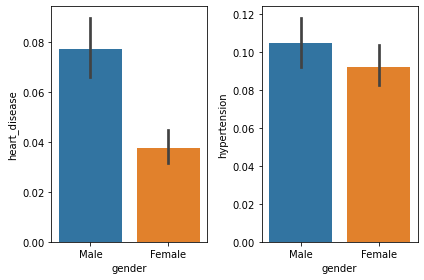

In [58]:
fid, ax = plt.subplots(1, 2)

ax1 = sns.barplot(data=df, x='gender', y='heart_disease', ax=ax[0])
ax2 = sns.barplot(data=df, x='gender', y='hypertension', ax=ax[1])

plt.tight_layout()

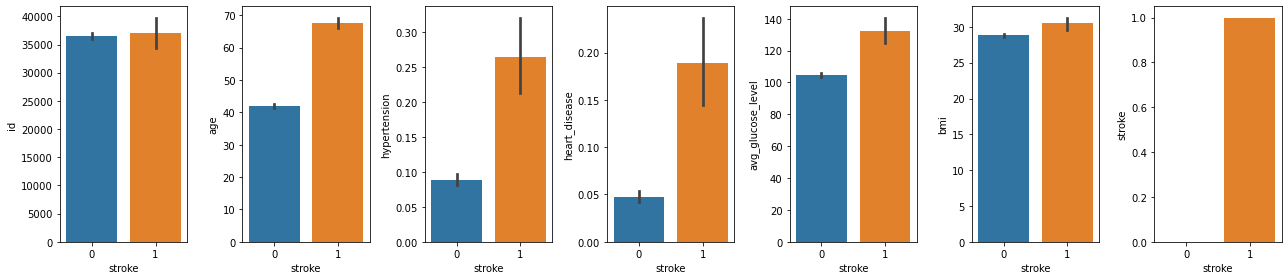

In [59]:
fig, ax = plt.subplots(1, len(num_features), figsize=(18,4))

for i in range(len(num_features)):
    sns.barplot(data=df, x='stroke', y=num_features[i], ax=ax[i])
    plt.tight_layout()


In [60]:
# imbalance dataset
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [61]:
# imbalance dataset (in percent)
df['stroke'].value_counts()/len(df['stroke'])*100

0    95.126248
1     4.873752
Name: stroke, dtype: float64

**Statistical Test**

In [117]:
feat_cat = list(df.describe(include='object'))
feat_cat

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [118]:
feat_num = list(df.describe())
feat_num

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [120]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [128]:
df['bmi'].fillna(df['bmi'].median(), inplace=True)

In [129]:
def tes_mann(col):

    u_stat, pvalue = mannwhitneyu(
        df[df['stroke']==0][col],
        df[df['stroke']==1][col],
        alternative='two-sided'
    )

    return pvalue

In [130]:
for i in feat_num:
    print(tes_mann(i),'\t', i)

3.8497341579673305e-71 	 age
6.223303385323122e-20 	 hypertension
5.333441955233458e-22 	 heart_disease
3.583094987269707e-09 	 avg_glucose_level
0.00028131114526017245 	 bmi
0.0 	 stroke


## **Drop unused column**
column 'id' hanya berupa urutan nomor, tidak akan menentukan stroke 

In [62]:
# Drop unused column
df.drop(columns=['id'], inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## **Define X and y**

In [63]:
X = df.drop(columns=['stroke'], axis=1)
y = df['stroke']

In [64]:
y.value_counts() / len(X)*100

0    95.126248
1     4.873752
Name: stroke, dtype: float64

## **Data Splitting**

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size = 0.2,
    random_state = 0
)

## **Pre-processing and Data Transform**

In [66]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [67]:
# Transformer
transformer = ColumnTransformer([
    ('imputer', IterativeImputer(max_iter=10, random_state=42), ['bmi']),
    ('one hot', OneHotEncoder(drop='first'), ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
],  remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputer', IterativeImputer(random_state=42),
                                 ['bmi']),
                                ('one hot', OneHotEncoder(drop='first'),
                                 ['gender', 'ever_married', 'work_type',
                                  'Residence_type', 'smoking_status'])])

In [68]:
# Scaler
scaler = StandardScaler()

## **Model Benchmark (without Balancing)**
Kita coba cari model bencmark terbaik dengan cross validation, tanpa imbalace treatment

In [69]:
# Define models
logreg = LogisticRegression(solver='liblinear', random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

# Define imbalance treatment methods
models = [knn, tree, logreg]

score = []
nilai_mean = []
nilai_std = []

for i in models:

    skfold = StratifiedKFold(n_splits=5)

    model_pipe = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('model', i)
    ])

    model_cv = cross_val_score(
        model_pipe, 
        X_train, 
        y_train, 
        cv=skfold, 
        scoring='f1', 
        error_score='raise'
        )

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

    print(model_cv, i)

[0.         0.04651163 0.04878049 0.09090909 0.08888889] KNeighborsClassifier()
[0.         0.08888889 0.04444444 0.         0.04651163] DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
[0. 0. 0. 0. 0.] LogisticRegression(random_state=0, solver='liblinear')


In [71]:
pd.DataFrame({
    'model':['knn', 'tree', 'logreg'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,0.055018,0.033388
1,tree,0.035969,0.033380
2,logreg,0.000000,0.000000


## **Model Benchmark --> Imbalance Data Treatment**

In [74]:
# Define models
logreg = LogisticRegression(solver='liblinear', random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

# Define imbalance treatment methods
models = [knn, tree, logreg]

score = []
nilai_mean = []
nilai_std = []

for i in models:

    smote = SMOTE(random_state=42)
    skfold = StratifiedKFold(n_splits=5)

    model_pipe = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('balancing', smote),
        ('model', i)
    ])

    model_cv = cross_val_score(
        model_pipe, 
        X_train, 
        y_train, 
        cv=skfold, 
        scoring='f1', 
        error_score='raise'
        )

    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

    print(model_cv, i)

[0.2183908  0.14634146 0.11299435 0.1375     0.12865497] KNeighborsClassifier()
[0.23484848 0.22047244 0.2293578  0.19166667 0.23175966] DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)
[0.27819549 0.25882353 0.21561338 0.20437956 0.21960784] LogisticRegression(random_state=0, solver='liblinear')


In [75]:
pd.DataFrame({
    'model':['knn', 'tree', 'logreg'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,0.148776,0.036509
1,tree,0.221621,0.015724
2,logreg,0.235324,0.028225


## **Tuning the benchmark model**

In [79]:
# Create the algorithm chains
smote = SMOTE()
model = LogisticRegression()

model_pipe = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('balancing', smote),
    ('model', model)
])

# Hyperparameter space
hyperparam_space = {
    'model__C':[100, 10, 1, 0.1, 0.01, 0.001],
    'model__solver':['liblinear','newton-cg']
}

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Hyperparameter tuning
grid_search = GridSearchCV(
    model_pipe, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [80]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         IterativeImputer(random_state=42),
                                                                         ['bmi']),
                                                                        ('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          

In [81]:
print('Best score:', grid_search.best_score_)
print('Best params:', grid_search.best_params_)

Best score: 0.23840855020581966
Best params: {'model__C': 1, 'model__solver': 'liblinear'}


## **Experiment 1: Tuning with KNN**

In [84]:
# Create the algorithm chains
smote = SMOTE()
model = KNeighborsClassifier()

estimator = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('balancing', smote),
    ('model', model)
])

# Hyperparameter space
hyperparam_space = {
    'model__n_neighbors':[3, 5, 7, 9, 11, 13],
    'model__weights':['uniform', 'distance']
}

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Hyperparameter tuning
grid_search_knn = GridSearchCV(
    estimator, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    n_jobs = -1 # use all cores
)

In [85]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('imputer',
                                                                         IterativeImputer(random_state=42),
                                                                         ['bmi']),
                                                                        ('one '
                                                                         'hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          

In [86]:
print('Best score:', grid_search_knn.best_score_)
print('Best params:', grid_search_knn.best_params_)

Best score: 0.16685556714915672
Best params: {'model__n_neighbors': 13, 'model__weights': 'uniform'}


Masih lebih bagus Logistic Regression

## **Experiment 2: Optimize Threshold with Logistic Regression**

In [96]:
grid_search.best_params_

{'model__C': 1, 'model__solver': 'liblinear'}

In [95]:
# Model LogReg after tuning
model = grid_search.best_estimator_
model.fit(X_train, y_train)

# ---------------------------------------
th_value = [i/100 for i in range(1,100)]

score_list = []

score = 0

# looping mencari nilai threshold terbaik
for i in th_value:

    # predict
    y_prob = model.predict_proba(X_test)[: , 1]
    y_pred = np.where(y_prob>i, 1, 0)

    score_temp = f1_score(y_test, y_pred)
    score_list.append(score_temp)

    if score_temp > score:
        score = score_temp

        best_score = score
        best_th = i

In [97]:
print('Best f1 score: ', best_score)
print('Best threshold: ', best_th)

Best f1 score:  0.2644628099173554
Best threshold:  0.85


<AxesSubplot:>

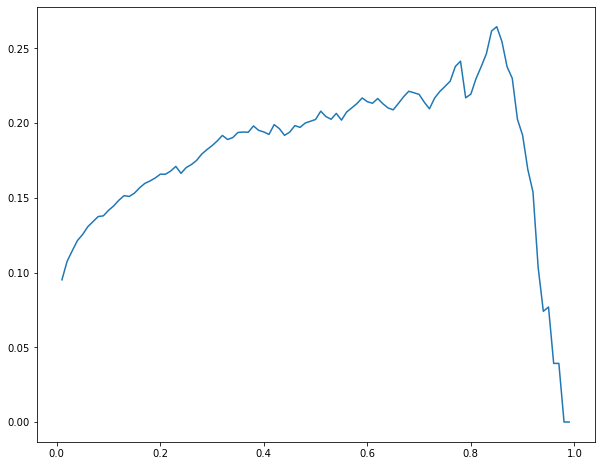

In [98]:
plt.figure(figsize=(10,8))
sns.lineplot(x=th_value, y=score_list)

In [99]:
# Predict dengan threshold terbaik

# Model LogReg after tuning
model = grid_search.best_estimator_
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:,1]
y_pred = np.where(y_prob> best_th , 1, 0)

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       972
           1       0.22      0.32      0.26        50

    accuracy                           0.91      1022
   macro avg       0.59      0.63      0.61      1022
weighted avg       0.93      0.91      0.92      1022



## **Experiment 3: Penalized**

In [106]:
grid_search.best_params_

{'model__C': 1, 'model__solver': 'liblinear'}

In [111]:
# Create the algorithm chains
smote = SMOTE()
model_balance = LogisticRegression(class_weight='balanced', C=1, solver='liblinear')

model_balance_pipe = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('balancing', smote),
    ('model', model_balance)
])

model_balance_pipe.fit(X_train, y_train)

# y_pred = model_balance_pipe.predict(X_test)

y_prob = model_balance_pipe.predict_proba(X_test)[:,1]
y_pred = np.where(y_prob> best_th , 1, 0)

f1_score(y_test, y_pred)

0.2833333333333333

In [113]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       972
           1       0.24      0.34      0.28        50

    accuracy                           0.92      1022
   macro avg       0.60      0.64      0.62      1022
weighted avg       0.93      0.92      0.92      1022



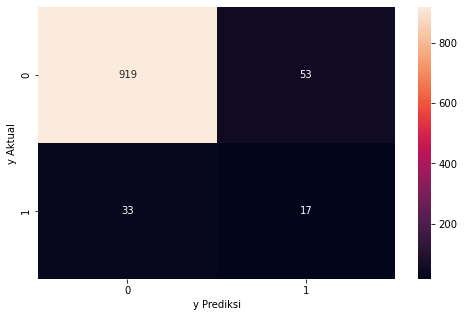

In [112]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

## **Model Prediction in Test Set**

### **Before**

In [101]:
smote = SMOTE()
model =  LogisticRegression()

estimator = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('balancing', smote),
    ('model', model)
])

estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84       972
           1       0.12      0.68      0.20        50

    accuracy                           0.74      1022
   macro avg       0.55      0.71      0.52      1022
weighted avg       0.94      0.74      0.81      1022



### **After**

In [102]:
model_final = grid_search.best_estimator_

model_final.fit(X_train, y_train)

y_pred_tuning = model_final.predict(X_test) 

In [103]:
print(classification_report(y_test, y_pred_tuning))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       972
           1       0.12      0.68      0.21        50

    accuracy                           0.74      1022
   macro avg       0.55      0.71      0.53      1022
weighted avg       0.94      0.74      0.82      1022



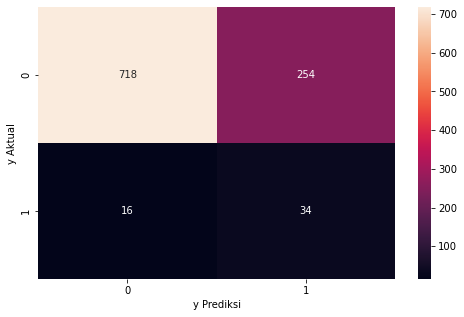

In [104]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

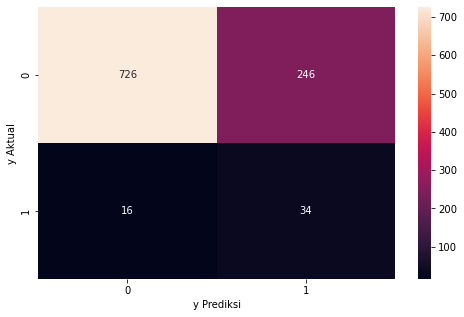

In [105]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

## **Interpretasi**

TP: Model memprediksi orang mengidap penyakit stroke dan aktualnya memang iya (40).<br>
FP: Model memprediksi orang mengidap penyakit stroke, tetapi aktualnya tidak (258).
<br><br>

TN: Model memprediksi orang tidak mengidap penyakit stroke dan aktualnya memang tidak (714).<br>
FN: Model memprediksi orang tidak mengidap penyakit stroke, tetapi aktualnya mengidap penyakit stroke (10).
<br><br>

Pada kasus prediksi pasien penderita stroke ini, menekan nilai FN sebenarnya lebih penting dari pada FP. 
- FN (False Negative) menyebabkan seorang yang terjangkit stroke tidak terdeteksi, sehingga tidak akan mendapatkan pengobatan.
- FP (False Positive) menyebabkan orang yang tidak stroke dianngap stroke. Jika ini terjadi, dokter biasanya akan melakukan crosscheck untuk memastikan orang tersebut benar2 menderita stroke.


Tidak terdapat perbedaan signifikan antara hasil sebelum dan sesudah tuning. Karena jumlah sample kelas negatif jauh lebih banyak dari kelas positif, dari confusion matrix plot dapat dilihat bahwa banyak terdapat samples kelas negatif yang bisa menjadi false positive. Sebaliknya, karena sample kelas positif hanya berjumlah sedikit, maka sedikit pula samples kelas positif yang menjadi false negatif. 